# Bayesian Linear Models in `numpyro`

Quite possibly the simplest possible example of `numpyro` ever.

From: [Persuasive Python: Bayesian Linear Models](https://www.persuasivepython.com/10-linpred)

Imagine a most basic example in which we want to estimate the sales price (in \$K) of a home given the square footage of the home.

In [76]:
## make two data arrays representing observations
## of home sales

salesPrice = [590, 575, 550, 520, 545, 
              575, 550, 510, 595, 600]
sqFootage = [2057, 1713, 1791, 1472, 1481, 
             1642, 1727, 1468, 1801, 1713]
numBed = [3, 4, 4, 3, 3, 4, 4, 3, 4, 4]

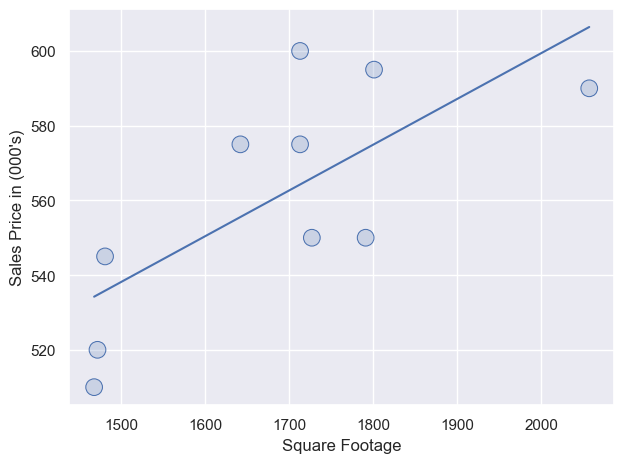

In [77]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import numpy as np

(
    so.Plot(x=sqFootage, y=salesPrice)
    .add(so.Dots(pointsize = 12)) ## big points
    .add(so.Line(), so.PolyFit(order = 1)) ## adds regression line
    .label(x="Square Footage", y="Sales Price in (000's)")
    .show()
)

We can use polyfit to get the coefficients via OLS:

In [89]:
np.polyfit(np.array(sqFootage), np.array(salesPrice), deg=1, )

array([1.22556924e-01, 3.54307747e+02])

The model:

$$
\begin{aligned}
y &\sim N(\mu, \sigma) \\
\mu_i &= \alpha + \beta x_i
\end{aligned}
$$

where:

$$
\begin{aligned}
x_i &= \text{The value of an explanatory variable for the } i^{th} \text{ observation}\\
\alpha &= \text{Intercept}\\
\beta &= \text{Coefficients}\\
\mu_i &= \text{Expected value for the } i^{th} \text{ observation}
\end{aligned}
$$

With the specific example, $x$ is the square footage and $\beta$ will represent the expected price per sq foot. 

In [79]:
import numpyro
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

## Convert observed data to arrays - numpyro will NOT accept a pandas series as input
salesPriceData = jnp.array(salesPrice)
sqFootageData = jnp.array(sqFootage)

# 1. Spec Model
def salesPriceModel(salesPriceArray, sqFootageArray):
    """
	In numpyro, we specify the model as a python function
	"""
    beta = numpyro.sample('beta', dist.Normal(0.275, 0.8))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    with numpyro.plate("obs", len(salesPriceArray)):
        mu = numpyro.deterministic("mu", beta * sqFootageArray)
        y = numpyro.sample('y', dist.Normal(loc = mu, scale = sigma), 
                        obs=salesPriceArray)

# 2. Run Inference engine to get posterior 
nuts_kernel = NUTS(salesPriceModel)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000) 
# jax needs a rng key
rng_key = random.PRNGKey(seed = 42)
# running with the observations
mcmc.run(rng_key, salesPriceArray = salesPriceData, sqFootageArray = sqFootageData) 

## get representative sample of posterior
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2888.10it/s, 7 steps of size 7.38e-01. acc. prob=0.93]


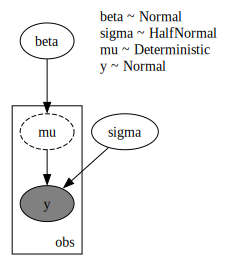

In [80]:
# Render model with graphviz
numpyro.render_model(salesPriceModel, 
                     model_args=(salesPriceData, sqFootageData),
                     render_params=True,
                     render_distributions=True)

In [81]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.33      0.01      0.33      0.32      0.34   1103.90      1.00
     sigma     31.79      4.12     31.53     25.00     37.87   1059.27      1.00

Number of divergences: 0


In [82]:
# Get data out as an xarray using arviz .from_numpyro() method
data = az.from_numpyro(mcmc)

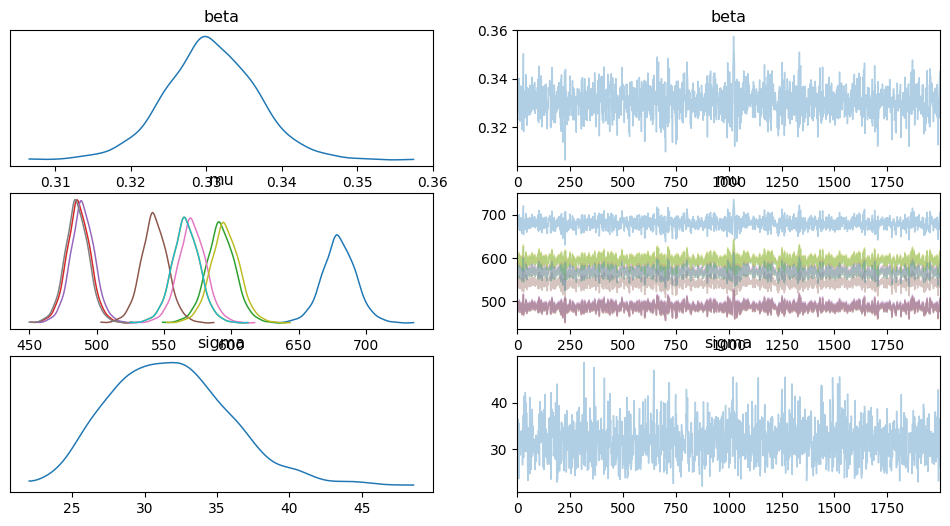

In [83]:
# useful plot
az.plot_trace(data, compact=True);

<Axes: title={'center': 'beta'}>

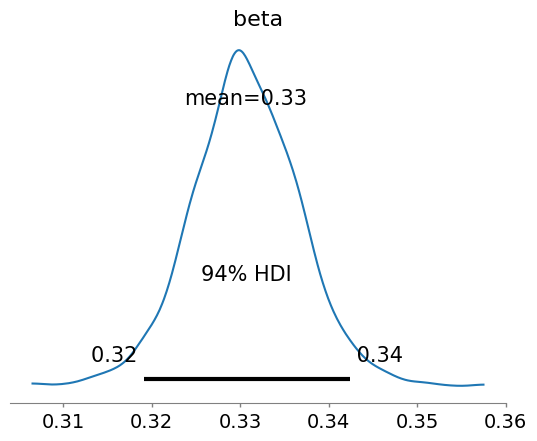

In [84]:
# Analyzing posterior distribution
az.plot_posterior(data, var_names=['beta'])

<Axes: title={'center': 'beta'}>

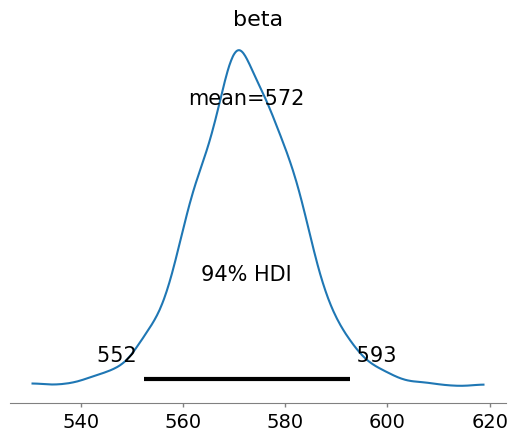

In [85]:
# Then our expected revenue would be:
az.plot_posterior(data.posterior.beta * 1731)

In [86]:
az.summary(data)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.331,0.006,0.319,0.342,0.000,0.000,1159.0,787.0,NaN
mu[0],680.107,12.623,656.325,704.197,0.379,0.269,1159.0,787.0,NaN
mu[1],566.370,10.512,546.565,586.431,0.315,0.224,1159.0,787.0,NaN
mu[2],592.159,10.991,571.453,613.134,0.330,0.234,1159.0,787.0,NaN
mu[3],486.688,9.033,469.670,503.927,0.271,0.192,1159.0,787.0,NaN
mu[4],489.664,9.089,472.541,507.008,0.273,0.193,1159.0,787.0,NaN
mu[5],542.896,10.077,523.911,562.125,0.302,0.214,1159.0,787.0,NaN
mu[6],571.000,10.598,551.032,591.224,0.318,0.225,1159.0,787.0,NaN
mu[7],485.366,9.009,468.393,502.558,0.270,0.192,1159.0,787.0,NaN
mu[8],595.466,11.052,574.643,616.557,0.332,0.235,1159.0,787.0,NaN


In [87]:
jnp.mean(data.posterior.beta.values) * 1731

Array(572.3217, dtype=float32)

## Posterior Predictive

In [88]:
# predictive = Predictive(salesPriceModel, drawsDS)
# forecast_marginal = predictive(random.PRNGKey(1), salesPriceArray = salesPriceData, 
#          sqFootageArray = sqFootageData, 
#          numObs = len(salesPriceData))